In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset
import numpy as np
from stacked_deep_sets import DSS
from tqdm import tqdm
import os

gpu_id = 0
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

class SetToyDataset(Dataset):
    def __init__(self, gen_fn, length, order=0):
        super().__init__()
        self.gen_fn = gen_fn
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        x, y = self.gen_fn()
        
        return x, y

def train(model, max_steps=2000, lr=1e-4, gen_data=None):

    dataloader = torch.utils.data.DataLoader(
        SetToyDataset(gen_data, length=999999),
        batch_size=1, num_workers=16)
    data_iter = iter(dataloader)
    model = model.cuda('cuda:%d'%gpu_id)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.1)
    criterion = nn.CrossEntropyLoss().cuda('cuda:%d'%gpu_id)
    losses = []
    accs = []
    model.train()
    for i in (pbar := tqdm(range(max_steps), desc='Loss: 0.00000, Acc: 0.00000')):
        if i > 0 and i % int(max_steps*0.3) == 0:
            # set lr
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.5
        x, y = next(data_iter)
        x = x[0].float().cuda('cuda:%d'%gpu_id)
        y = y[0].cuda('cuda:%d'%gpu_id) # (B, N)
        pred = model(x) # (B, C, N)
        if len(pred.shape) == 2:
            pred = pred.unsqueeze(-1) # (B, C) -> (B, C, 1)
        acc = (pred.argmax(dim=1) == y).float().mean() # (B, N)
        pred = pred.permute(0, 2, 1) # (B, N, C)
        B, N, C = pred.shape
        pred = pred.reshape(B*N, C)
        y = y.reshape(B*N)
        loss = criterion(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss = loss.item()
        acc = acc.item()
        pbar.set_description(f'Loss: {loss:.5f}, Acc: {acc:.5f}')
        losses.append(loss)
        accs.append(acc)
    del dataloader
    return losses, accs

def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed

import matplotlib.pyplot as plt
import matplotlib.cm as cm
def plot_acc(acc, name, index, dotted=False):
    # cmap = cm.get_cmap('tab10')
    cmap = cm.get_cmap('Dark2')
    color = cmap(index)
    # convert to a dark color
    color = (np.array(color) * 0.8).tolist()

    acc = smooth(acc, 0.95)
    x = np.arange(len(acc))
    plt.plot(x, acc, label=name, color=color, linestyle='--' if dotted else '-')

def plot_show(save_path=None):
    plt.legend()
    plt.xlabel("Trained Samples (k)")
    plt.ylabel("Accuracy")
    # set size
    plt.gcf().set_size_inches(6, 4)

    plt.grid(linestyle='--', color='gray', linewidth=0.5, alpha=0.5)
    # save fig
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Loss: 0.16254, Acc: 0.93399: 100%|██████████| 2000/2000 [01:34<00:00, 21.20it/s]


DSS (quant) 0.9713946533203125
DSS (max) 0.5345654296875
DSS (avg) 0.9311846923828125


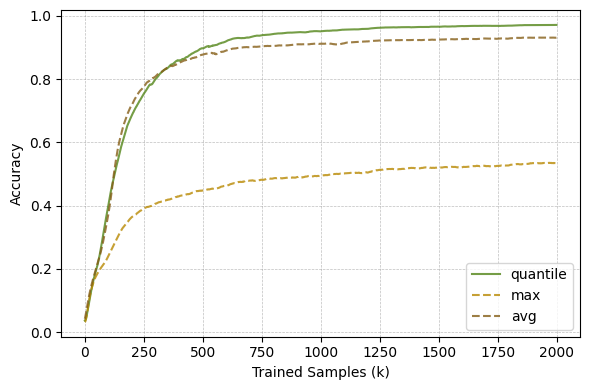

In [2]:

def gen_data_sort(batch_size, max_v=10, max_length=32, perturbation=0.01):
    # y is the second largest number
    length = max_length
    x = np.random.randint(1, max_v, (batch_size, length))
    perturbations = np.random.normal(0, perturbation, x.shape)
    x_p = x + perturbations
    x = np.sort(x_p, axis=1)
    indices = np.argsort(x, axis=1)

    y = indices
    # shuffle_indices = np.random.permutation(length)
    # x = x[:, shuffle_indices]
    # y = y[:, shuffle_indices]
    x = x[..., None]
    return x, y

def gen_data():
    return gen_data_sort(batch_size=2 ** 10, max_v=4, max_length=32, perturbation=0.1)

import functools
_DSS = functools.partial(DSS, in_channels=1, out_channels=32, d_model=256, num_layers=6, single_output=False)

models = [
    ("DSS (quant)", _DSS(pool="quant")),
    ("DSS (max)", _DSS(pool="max")),
    ("DSS (avg)", _DSS(pool="mean")),
]

plot_map = {}
for _name, _model in models:
    _losses, _accs = train(_model, max_steps=2000, gen_data=gen_data)
    plot_map[_name] = _accs

for i, (_name, _model) in enumerate(models):
    acc = plot_map[_name]
    last_few = acc[-50:]
    mean_acc = np.mean(last_few)
    print(_name, mean_acc)

for i, (_name, _model) in enumerate(models):
    if 'max' in _name:
        name = 'max'
    elif 'avg' in _name:
        name = 'avg'
    elif 'quant' in _name:
        name = 'quantile'
    plot_acc(plot_map[_name], name, i+4, dotted=False if 'quant' in _name else True)

plot_show(save_path=None)

Loss: 1.24292, Acc: 0.45996: 100%|██████████| 2000/2000 [02:37<00:00, 12.68it/s]


DSS (quant) 0.482421875
DSS (max) 0.45896484375
DSS (avg) 0.443203125


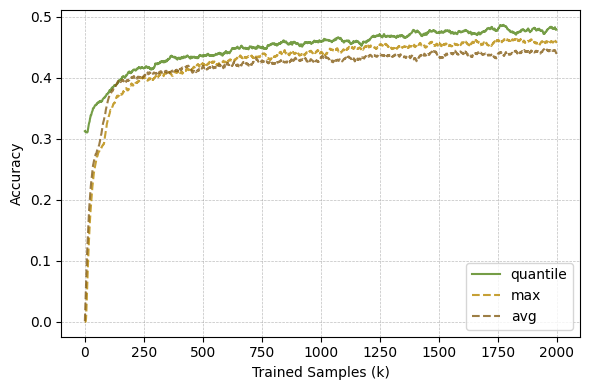

In [3]:
import bisect
def max_envolopes(dolls):
    # dolls: (N, 2)
    assert dolls.shape[1] == 2
    dolls = sorted(dolls, key=lambda x: (x[0], -x[1]))
    res = []
    for _, h in dolls:
        p = bisect.bisect_left(res, h)
        if p == len(res):
            res.append(h)
        else:
            res[p] = h
    return len(res)

def gen_data_russion_doll_float(batch_size, max_length=10, low=0, high=1):
    length = max_length
    x = np.random.uniform(low=low, high=high, size=(batch_size, length, 2))
    y = []
    for i in range(batch_size):
        y.append(max_envolopes(x[i]))
    x_feat = np.zeros((batch_size, length, 2), dtype=np.float32)
    x_feat[..., 0:2] = x
    x = x_feat
    y = np.array(y)
    y = np.expand_dims(y, axis=1)
    return x, y

def gen_data():
    return gen_data_russion_doll_float(batch_size=2 ** 10, max_length=32)

import functools
_DSS = functools.partial(DSS, in_channels=2, out_channels=32, d_model=256, num_layers=16, single_output=True)

models = [
    ("DSS (quant)", _DSS(pool="quant")),
    ("DSS (max)", _DSS(pool="max")),
    ("DSS (avg)", _DSS(pool="mean")),
]

plot_map = {}
for _name, _model in models:
    _losses, _accs = train(_model, max_steps=2000, gen_data=gen_data)
    plot_map[_name] = _accs

for i, (_name, _model) in enumerate(models):
    acc = plot_map[_name]
    last_few = acc[-50:]
    mean_acc = np.mean(last_few)
    print(_name, mean_acc)

for i, (_name, _model) in enumerate(models):
    if 'max' in _name:
        name = 'max'
    elif 'avg' in _name:
        name = 'avg'
    elif 'quant' in _name:
        name = 'quantile'
    plot_acc(plot_map[_name], name, i+4, dotted=False if 'quant' in _name else True)

plot_show(save_path=None)